SPDX-License-Identifier: MIT — See LICENSE for full terms
> Created by Patrick Woo, 2025  
> This file is part of the FPS-R (Frame-Persistent Stateless Randomisation) project.  
> https://github.com/patwooky/fpsr

# **FPS-R**

## **Frame-Persistent Stateless Randomisation**
**FPS-R** stands for **Frame-Persistent Stateless Randomisation**. It is a philosophy and framework behind a collection of lightweight algorithmic pattern for simulating persistent yet stateless randomness across a continuous timeline—ideal for procedural motion, glitch aesthetics, synthesised organic behaviour, and analogue artefact emulation.

### Algorithms
This notebook will provide the Python code for the following FPS-R Algorithms:
- **Stacked Modulo (SM)**
- **Toggled Modulo (TM)**
- **Quantised Switching (QS)**

In [21]:
# import libraries
import os
import sys
import json
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add inline plotting for matplotlib
%matplotlib inline

#### Helper Random Number Generator
To ensure repeatability and portability across platforms, a helper random number generator is included here. Feel free to use the native RNG of the platform that is relevant to your code.

In [22]:
import math

def portable_rand(seed):
    """
    A simple, portable pseudo-random number generator.
    Generates a deterministic float between 0.0 and 1.0 from an integer seed.
    Different languages have different rand() implementations, so using a custom
    one like this ensures identical results on any platform.
    
    Args:
        seed (int): An integer used to generate the random number.

    Returns:
        float: A pseudo-random float between 0.0 and 1.0.
    """
    # A common technique for a simple hash-like random number.
    # The large prime numbers are used to create a chaotic, unpredictable result.
    val = float(seed) * 12.9898
    
    # --- FIX for float precision on GPUs and other platforms ---
    # By using the mathematical property sin(x) = sin(x mod 2π), we can wrap the
    # input to sin() into a high-precision range, ensuring the result
    # remains stable and correct indefinitely.
    # Python's math.fmod is the C equivalent, and math.pi is available.
    val = math.fmod(val, 2 * math.pi)

    result = math.sin(val) * 43758.5453
    
    # Python's equivalent of frac()
    return result - math.floor(result)

## FPS-R: Stacked Modulo (SM)

In [ ]:
"""
--------------------------
FPS-R: Stacked Modulo (SM)
--------------------------
"""

def fpsr_sm(frame, 
            minHold, maxHold, 
            reseedInterval, 
            seedInner, seedOuter, 
            finalRandSwitch=True):
    """
    Produces a pseudo-random value that persists across multiple frames, held for a calculated duration.
    The hold timing varies over time, driven by deterministic interference between reseeded modular rhythms.
    This method mimics structured hesitation and twitch-like behavior—creating motion that feels deliberate without relying on state or memory.
    
    Args:
        int frame: The current frame or time input.
        int minHold: The minimum duration (in frames) for a value to hold.
        int maxHold: The maximum duration (in frames) for a value to hold.
        int reseedInterval: The fixed interval at which a new hold duration is calculated.
        int seedInner: An offset for the random duration calculation to create unique sequences.
        int seedOuter: An offset for the final value calculation to create unique sequences.
        bool finalRandSwitch: A flag to enable/disable the final randomisation step.
    
    Returns:
        float: If finalRandSwitch is True, a random value between 0.0 and 1.0. 
               If False, the raw integer state value.
    """
    # --- 1. Calculate the random hold duration ---
    if reseedInterval < 1:
        reseedInterval = 1  # Prevent division by zero.

    rand_for_duration = portable_rand(seedInner + frame - (frame % reseedInterval))
    holdDuration = math.floor(minHold + rand_for_duration * (maxHold - minHold))

    if holdDuration < 1:
        holdDuration = 1  # Prevent division by zero.

    # --- 2. Generate the stable integer "state" for the hold period ---
    # This value is constant for the entire duration of the hold.
    held_integer_state = (seedOuter + frame) - ((seedOuter + frame) % holdDuration)

    # --- 3. Use the stable state as a seed for the final random value (or bypass) ---
    # Because the seed is stable, the final value is also stable.
    if finalRandSwitch:
        # If finalRandSwitch is true, we apply the final randomisation step.
        fpsr_output = portable_rand(held_integer_state)
    else:
        # If finalRandSwitch is false, we return the raw integer state directly.
        fpsr_output = float(held_integer_state)
    
    return fpsr_output

Sample code to call the **FPS-R: SM** function

In [24]:
# Sample code to call the function
# Parameters
frame = 100  # Replace with the current frame value
minHoldFrames = 16  # probable minimum held period
maxHoldFrames = 24  # maximum held period before cycling
reseedFrames = 9    # inner mod cycle timing
offsetInner = -41   # offsets the inner frame
offsetOuter = 23    # offsets the outer frame
use_final_random = True # Set to False to bypass final randomization

# Call the FPS-R:SM function
randVal = fpsr_sm(frame, minHoldFrames, maxHoldFrames, reseedFrames, offsetInner, offsetOuter, use_final_random)
# Another call to fpsr_sm for the previous frame
randVal_previous = fpsr_sm(frame - 1, minHoldFrames, maxHoldFrames, reseedFrames, offsetInner, offsetOuter, use_final_random)

# Check if the value has changed
changed = 1 if randVal != randVal_previous else 0

print("--- Stacked Modulo (SM) Sample ---")
print(f'randVal_previous: {randVal_previous}')
print(f'randVal: {randVal}')
print(f'changed: {changed}\n')

--- Stacked Modulo (SM) Sample ---
randVal_previous: 0.7168683790368959
randVal: 0.7168683790368959
changed: 0



## FPS-R: Toggled Modulo (TM)

In [ ]:
"""
---------------------------
FPS-R: Toggled Modulo (TM)
---------------------------
"""

def fpsr_tm(frame, 
            periodA, periodB, 
            periodSwitch, 
            seedInner, seedOuter, 
            finalRandSwitch=True):
    """
    Generates a persistent value that holds for a rhythmically toggled duration.
    This function uses a deterministic switch to toggle the hold duration
    between two fixed periods. This creates a predictable, rhythmic, or mechanical
    "move-and-hold" pattern, as opposed to the organic randomness of SM.

    Args:
        frame (int): The current frame or time input.
        periodA (int): The first hold duration (in frames).
        periodB (int): The second hold duration (in frames).
        periodSwitch (int): The fixed interval at which the hold duration is toggled.
        seedInner (int): An offset for the toggle clock to de-sync it from the main clock.
        seedOuter (int): An offset for the main clock to create unique output sequences.
        finalRandSwitch (bool): A flag to enable/disable the final randomisation step.

    Returns:
        float: If finalRandSwitch is True, a random value between 0.0 and 1.0. 
               If False, the raw integer state value.
    """
    # --- 1. Determine the hold duration by toggling between two periods ---
    if periodSwitch < 1:
        periodSwitch = 1  # Prevent division by zero.

    # The "inner clock" is offset by seedInner to de-correlate it from the main frame.
    inner_clock_frame = seedInner + frame
    
    # The ternary switch: toggle between periodA and periodB at a fixed rhythm.
    if (inner_clock_frame % periodSwitch) < (periodSwitch * 0.5):
        holdDuration = periodA
    else:
        holdDuration = periodB

    if holdDuration < 1:
        holdDuration = 1  # Prevent division by zero.

    # --- 2. Generate the stable integer "state" for the hold period ---
    # The "outer clock" is offset by seedOuter to create unique output sequences.
    outer_clock_frame = seedOuter + frame
    held_integer_state = outer_clock_frame - (outer_clock_frame % holdDuration)

    # --- 3. Use the stable state as a seed for the final random value (or bypass) ---
    if finalRandSwitch:
        # If true, apply the final randomisation hash.
        fpsr_output = portable_rand(held_integer_state)
    else:
        # If false, return the raw integer state directly.
        fpsr_output = float(held_integer_state)
    
    return fpsr_output

# end of fpsr_tm function

Sample code to call the **FPS-R: TM** function

In [28]:
# Sample code to call the FPS-R:TM function
# Parameters
frame = 100  # Replace with the current frame value
period_A = 10  # The first hold duration
period_B = 25  # The second hold duration
switch_duration = 30  # The toggle happens every 30 frames
offset_inner = 15  # offsets the inner (toggle) clock
offset_outer = 0  # offsets the outer (hold) clock
use_final_random = True  # Set to False to bypass final randomization

# Call the FPS-R:TM function
randVal = fpsr_tm(frame, period_A, period_B, switch_duration, offset_inner, offset_outer, use_final_random)
# Another call to fpsr_tm for the previous frame
randVal_previous = fpsr_tm(frame - 1, period_A, period_B, switch_duration, offset_inner, offset_outer, use_final_random)

# Check if the value has changed
changed = 1 if randVal != randVal_previous else 0

print("--- Toggled Modulo (TM) Sample ---")
print(f'randVal_previous: {randVal_previous}')
print(f'randVal: {randVal}')
print(f'changed: {changed}\n')

--- Toggled Modulo (TM) Sample ---
randVal_previous: 0.5948926140772528
randVal: 0.2641387128533097
changed: 1



## FPS-R: Quantised Switching (QS)

In [ ]:
"""
-------------------------------
FPS-R: Quantised Switching (QS)
-------------------------------
"""

def fpsr_qs(frame, 
            baseWaveFreq, stream2FreqMult, quantLevelsMinMax, 
            streamsOffset, quantOffsets,
            streamSwitchDur, 
            stream1QuantDur, stream2QuantDur, 
            finalRandSwitch=True):
    """
    Generates a flickering, quantised value by switching between two sine wave streams.
    For each stream, a new random quantisation level is chosen from within the [min, max] 
    range at a set interval. The function then switches between these two streams to create
    complex, glitch-like patterns.
    
    Args:
        frame (int): The current frame or time input.
        baseWaveFreq (float): The base frequency for the modulation wave of stream 1.
        stream2FreqMult (float): A multiplier for the second stream's frequency.
        quantLevelsMinMax (list[int]): A list of two integers for the min and max quantisation levels.
        streamsOffset (list[int]): A list of two integers to offset the frame for each stream's sine wave.
        quantOffsets (list[int]): A list of two integers to offset the random quantisation selection for each stream.
        streamSwitchDur (int): The number of frames after which the streams switch.
        stream1QuantDur (int): The duration for which stream 1'sf random quantisation level is held.
        stream2QuantDur (int): The duration for which stream 2's random quantisation level is held.
        finalRandSwitch (bool): A flag to enable/disable the final randomisation step.

    Returns:
        float: If finalRandSwitch is True, a random value between 0.0 and 1.0. 
               If False, the raw stepped signal value, scaled to the [0, 1] range.
    """
    # --- 1. Set default durations if not provided ---
    if streamSwitchDur < 1: streamSwitchDur = math.floor((1.0 / baseWaveFreq) * 0.76)
    if stream1QuantDur < 1: stream1QuantDur = math.floor((1.0 / baseWaveFreq) * 1.2)
    if stream2QuantDur < 1: stream2QuantDur = math.floor((1.0 / baseWaveFreq) * 0.9)
    
    # Ensure durations are at least 1 frame to prevent division by zero.
    streamSwitchDur = max(streamSwitchDur, 1)
    stream1QuantDur = max(stream1QuantDur, 1)
    stream2QuantDur = max(stream2QuantDur, 1)

    # --- 2. Calculate random quantisation levels for each stream ---
    quant_min = quantLevelsMinMax[0]
    quant_max = quantLevelsMinMax[1]
    quant_range = quant_max - quant_min + 1

    # --- Stream 1 Quant Level ---
    s1_quant_seed = (quantOffsets[0] + frame) - ((quantOffsets[0] + frame) % stream1QuantDur)
    s1_rand_for_quant = portable_rand(s1_quant_seed)
    s1_quant_level = quant_min + math.floor(s1_rand_for_quant * quant_range)

    # --- Stream 2 Quant Level ---
    s2_quant_seed = (quantOffsets[1] + frame) - ((quantOffsets[1] + frame) % stream2QuantDur)
    s2_rand_for_quant = portable_rand(s2_quant_seed)
    s2_quant_level = quant_min + math.floor(s2_rand_for_quant * quant_range)

    s1_quant_level = max(s1_quant_level, 1)
    s2_quant_level = max(s2_quant_level, 1)

    # --- 3. Generate the two quantised sine wave streams ---
    if stream2FreqMult < 0: stream2FreqMult = 3.7

    stream1 = math.floor(math.sin((streamsOffset[0] + frame) * baseWaveFreq) * s1_quant_level) / s1_quant_level
    stream2 = math.floor(math.sin((streamsOffset[1] + frame) * baseWaveFreq * stream2FreqMult) * s2_quant_level) / s2_quant_level

    # --- 4. Switch between the two streams ---
    active_stream_val = stream1 if (frame % streamSwitchDur) < streamSwitchDur / 2 else stream2

    # --- 5. Hash the final output to create a random-looking value (or bypass) ---
    if finalRandSwitch:
        # If finalRandSwitch is true, we apply the final randomisation step.
        fpsr_output = portable_rand(int(active_stream_val * 100000.0))
    else:
        # If finalRandSwitch is false, we must scale the sine curve ranges (-1 to 1)
        # to 0 to 1 before we can return the active stream value.
        fpsr_output = 0.5 * active_stream_val + 0.5
        
    return fpsr_output

Sample code to call the **FPS-R: QS** function

In [33]:
# Sample code to call the FPS-R:QS function
# Parameters
frame = 103  # Current frame number
baseWaveFreq = 0.012  # Base frequency for the modulation wave of stream 1
stream2freqMult = 3.1  # Multiplier for the second stream's frequency
quantLevelsMinMax = [12, 22]  # Min, Max quantisation levels for the two streams
streamsOffset = [0, 76]  # Offset for the two streams
quantOffsets =[10, 81] # Offset for the random quantisation selection
streamSwitchDur = 24  # Duration for switching streams in frames
stream1QuantDur = 16  # Duration for the first stream's quantisation switch cycle in frames
stream2QuantDur = 20  # Duration for the second stream's quantisation switch cycle in frames
use_final_random = True # Set to False to bypass final randomization

# Call the FPS-R:QS function
randVal = fpsr_qs(
    frame, baseWaveFreq, stream2freqMult, quantLevelsMinMax, 
    streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, use_final_random
)

# Another call to fpsr_qs for the previous frame
randVal_previous = fpsr_qs(
    frame - 1, baseWaveFreq, stream2freqMult, quantLevelsMinMax, 
    streamsOffset, quantOffsets, streamSwitchDur, stream1QuantDur, stream2QuantDur, use_final_random
)

# Check if the value has changed
changed = 1 if randVal != randVal_previous else 0

print("--- Quantised Switching (QS) Sample ---")
print(f'randVal_previous: {randVal_previous}')
print(f'randVal: {randVal}')
print(f'changed: {changed}')

--- Quantised Switching (QS) Sample ---
randVal_previous: 0.872179741234504
randVal: 0.872179741234504
changed: 0


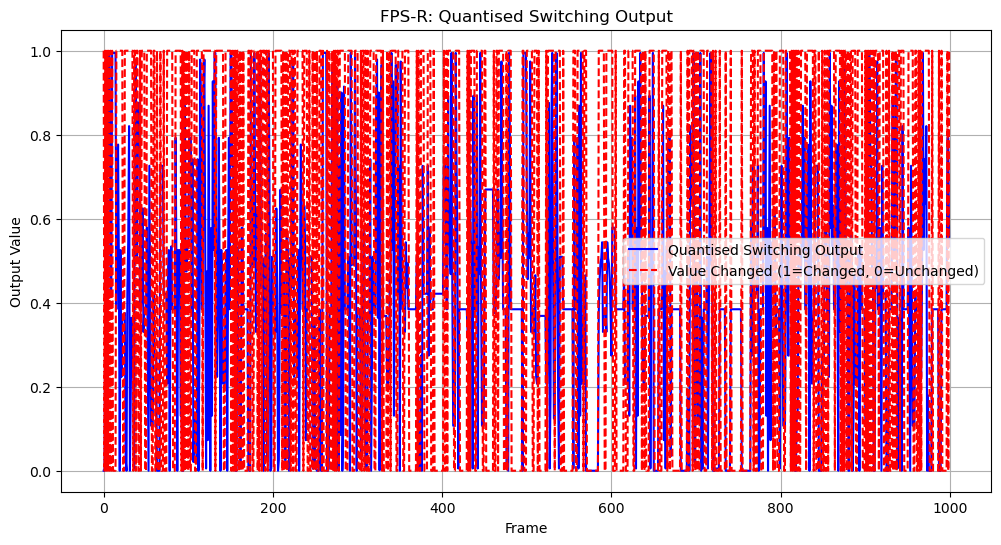

In [32]:
# plot quantised switching graph for 1000 steps
def plot_quantised_switching(steps=1000):
    """
    Plots the quantised switching graph for a given number of steps.
    
    Args:
        steps (int): The number of steps to simulate and plot.
    """
    baseWaveFreq = 0.1
    stream2FreqMult = 3.7
    quantLevelsMinMax = [1, 10]
    streamsOffset = [0, 100]
    quantOffsets = [50, 150]
    streamSwitchDur = 30
    stream1QuantDur = 20
    stream2QuantDur = 25

    values = []
    values_changed = []
    
    for frame in range(steps):
        value = fpsr_qs(frame, baseWaveFreq, stream2FreqMult, quantLevelsMinMax,
                        streamsOffset, quantOffsets, streamSwitchDur,
                        stream1QuantDur, stream2QuantDur)
        value_prev = fpsr_qs(frame - 1, baseWaveFreq, stream2FreqMult, quantLevelsMinMax,
                             streamsOffset, quantOffsets, streamSwitchDur,
                             stream1QuantDur, stream2QuantDur)
        values.append(value)
        values_changed.append(1 if value != value_prev else 0)

    plt.figure(figsize=(12, 6))
    plt.plot(values, label='Quantised Switching Output', color='blue')
    plt.plot(values_changed, label='Value Changed (1=Changed, 0=Unchanged)', color='red', linestyle='--')
    plt.title('FPS-R: Quantised Switching Output')
    plt.xlabel('Frame')
    plt.ylabel('Output Value')
    plt.grid()
    plt.legend()
    plt.show()
plot_quantised_switching()

### FPS-R: Stacked Modulo in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: SM**, interactively scrollable for your inspection pleasure.

### FPS-R: Toggled Modulo in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: TM**, interactively scrollable for your inspection pleasure.

### FPS-R: Quantised Switching in a Plot
The code below generates an interactive scrollable sample output of **FPS-R: QS**, interactively scrollable for your inspection pleasure.